In [31]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.models import DenseNet201_Weights, EfficientNet_B4_Weights

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score



In [32]:
# Dataset Path
dataset_path = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2'

train_dir = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2/train'
test_dir = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2/val'

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'val')

# Data Transforms for Inception_v3
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [33]:
# Load Dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Handle Class Imbalance
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✅ Classes:", train_dataset.classes)



✅ Classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


In [34]:
# Load Pretrained Inception_v3 Model
inception_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)

# Modify Fully Connected Layers
num_classes = 9  # Updated from 23 to 9
in_features_main = inception_model.fc.in_features
inception_model.fc = nn.Linear(in_features_main, num_classes)

if inception_model.aux_logits:
    in_features_aux = inception_model.AuxLogits.fc.in_features
    inception_model.AuxLogits.fc = nn.Linear(in_features_aux, num_classes)

# Move Model to Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using Device:", device)

inception_model = inception_model.to(device)



✅ Using Device: cuda


In [35]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Print Constant Learning Rate
print(f"✅ Constant Learning Rate: {optimizer.param_groups[0]['lr']}")


✅ Constant Learning Rate: 0.0001


In [37]:
# Training Configuration
num_epochs = 50
best_val_acc = 0.0
best_model = copy.deepcopy(inception_model.state_dict())

# Metrics Tracking
train_losses, val_losses = [], []
train_accs, val_accs = [], []
time_per_epoch = []

print("🚀 Starting Training for Inception_v3 (50 Epochs with Constant LR)...")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training Phase
    inception_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs, aux_outputs = inception_model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # Weighted loss for auxiliary outputs
        loss.backward()
        optimizer.step()
        
        running_loss += loss1.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * correct / total
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation Phase
    inception_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Handle model outputs based on training or evaluation mode
            outputs = inception_model(images)
            if inception_model.aux_logits:
                # When model is in eval mode, it returns only the primary output
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
            
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    epoch_val_loss = val_running_loss / len(test_dataset)
    epoch_val_acc = 100.0 * val_correct / val_total
    
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    epoch_time = time.time() - start_time
    time_per_epoch.append(epoch_time)
    
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | 🕒 {epoch_time:.2f}s | "
          f"📉 Train Loss: {epoch_train_loss:.4f} | 📈 Train Acc: {epoch_train_acc:.2f}% | "
          f"📉 Val Loss: {epoch_val_loss:.4f} | 📈 Val Acc: {epoch_val_acc:.2f}%")
    
    # Save Best Model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model = copy.deepcopy(inception_model.state_dict())

# Load Best Model
inception_model.load_state_dict(best_model)
print(f"✅ Training Complete! Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting Training for Inception_v3 (50 Epochs with Constant LR)...


Epoch 1/50: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s]


📊 Epoch [1/50] | 🕒 10.21s | 📉 Train Loss: 0.7998 | 📈 Train Acc: 75.47% | 📉 Val Loss: 0.6735 | 📈 Val Acc: 77.35%


Epoch 2/50: 100%|██████████| 44/44 [00:08<00:00,  5.13it/s]


📊 Epoch [2/50] | 🕒 9.92s | 📉 Train Loss: 0.5647 | 📈 Train Acc: 82.64% | 📉 Val Loss: 0.6315 | 📈 Val Acc: 79.56%


Epoch 3/50: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s]


📊 Epoch [3/50] | 🕒 10.48s | 📉 Train Loss: 0.3817 | 📈 Train Acc: 88.52% | 📉 Val Loss: 0.7517 | 📈 Val Acc: 76.24%


Epoch 4/50: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s]


📊 Epoch [4/50] | 🕒 10.14s | 📉 Train Loss: 0.3411 | 📈 Train Acc: 88.09% | 📉 Val Loss: 0.5156 | 📈 Val Acc: 81.22%


Epoch 5/50: 100%|██████████| 44/44 [00:08<00:00,  5.15it/s]


📊 Epoch [5/50] | 🕒 9.78s | 📉 Train Loss: 0.2895 | 📈 Train Acc: 91.10% | 📉 Val Loss: 0.5278 | 📈 Val Acc: 81.77%


Epoch 6/50: 100%|██████████| 44/44 [00:08<00:00,  5.05it/s]


📊 Epoch [6/50] | 🕒 9.98s | 📉 Train Loss: 0.1765 | 📈 Train Acc: 95.27% | 📉 Val Loss: 0.5351 | 📈 Val Acc: 82.32%


Epoch 7/50: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s]


📊 Epoch [7/50] | 🕒 10.38s | 📉 Train Loss: 0.2024 | 📈 Train Acc: 93.83% | 📉 Val Loss: 0.6297 | 📈 Val Acc: 81.77%


Epoch 8/50: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s]


📊 Epoch [8/50] | 🕒 10.22s | 📉 Train Loss: 0.1833 | 📈 Train Acc: 94.69% | 📉 Val Loss: 0.6473 | 📈 Val Acc: 82.87%


Epoch 9/50: 100%|██████████| 44/44 [00:08<00:00,  4.94it/s]


📊 Epoch [9/50] | 🕒 10.20s | 📉 Train Loss: 0.1702 | 📈 Train Acc: 94.26% | 📉 Val Loss: 0.5919 | 📈 Val Acc: 82.32%


Epoch 10/50: 100%|██████████| 44/44 [00:09<00:00,  4.86it/s]


📊 Epoch [10/50] | 🕒 10.47s | 📉 Train Loss: 0.1466 | 📈 Train Acc: 95.84% | 📉 Val Loss: 0.5865 | 📈 Val Acc: 81.77%


Epoch 11/50: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s]


📊 Epoch [11/50] | 🕒 10.34s | 📉 Train Loss: 0.1365 | 📈 Train Acc: 95.98% | 📉 Val Loss: 0.7558 | 📈 Val Acc: 81.77%


Epoch 12/50: 100%|██████████| 44/44 [00:09<00:00,  4.82it/s]


📊 Epoch [12/50] | 🕒 10.45s | 📉 Train Loss: 0.1016 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.6944 | 📈 Val Acc: 83.98%


Epoch 13/50: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s]


📊 Epoch [13/50] | 🕒 10.48s | 📉 Train Loss: 0.0821 | 📈 Train Acc: 98.13% | 📉 Val Loss: 0.6392 | 📈 Val Acc: 83.43%


Epoch 14/50: 100%|██████████| 44/44 [00:08<00:00,  5.02it/s]


📊 Epoch [14/50] | 🕒 10.02s | 📉 Train Loss: 0.0702 | 📈 Train Acc: 98.13% | 📉 Val Loss: 0.7524 | 📈 Val Acc: 84.53%


Epoch 15/50: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s]


📊 Epoch [15/50] | 🕒 9.88s | 📉 Train Loss: 0.0949 | 📈 Train Acc: 97.27% | 📉 Val Loss: 0.8040 | 📈 Val Acc: 78.45%


Epoch 16/50: 100%|██████████| 44/44 [00:09<00:00,  4.77it/s]


📊 Epoch [16/50] | 🕒 10.47s | 📉 Train Loss: 0.0675 | 📈 Train Acc: 98.13% | 📉 Val Loss: 0.6884 | 📈 Val Acc: 80.11%


Epoch 17/50: 100%|██████████| 44/44 [00:09<00:00,  4.88it/s]


📊 Epoch [17/50] | 🕒 10.33s | 📉 Train Loss: 0.0755 | 📈 Train Acc: 97.42% | 📉 Val Loss: 0.6287 | 📈 Val Acc: 83.43%


Epoch 18/50: 100%|██████████| 44/44 [00:08<00:00,  4.92it/s]


📊 Epoch [18/50] | 🕒 10.20s | 📉 Train Loss: 0.0940 | 📈 Train Acc: 97.13% | 📉 Val Loss: 0.6168 | 📈 Val Acc: 84.53%


Epoch 19/50: 100%|██████████| 44/44 [00:09<00:00,  4.68it/s]


📊 Epoch [19/50] | 🕒 10.67s | 📉 Train Loss: 0.0930 | 📈 Train Acc: 96.99% | 📉 Val Loss: 1.0200 | 📈 Val Acc: 79.56%


Epoch 20/50: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s]


📊 Epoch [20/50] | 🕒 10.19s | 📉 Train Loss: 0.0841 | 📈 Train Acc: 97.13% | 📉 Val Loss: 0.8552 | 📈 Val Acc: 80.11%


Epoch 21/50: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s]


📊 Epoch [21/50] | 🕒 10.15s | 📉 Train Loss: 0.0752 | 📈 Train Acc: 97.70% | 📉 Val Loss: 0.6822 | 📈 Val Acc: 86.19%


Epoch 22/50: 100%|██████████| 44/44 [00:08<00:00,  4.97it/s]


📊 Epoch [22/50] | 🕒 10.13s | 📉 Train Loss: 0.0575 | 📈 Train Acc: 98.57% | 📉 Val Loss: 0.6097 | 📈 Val Acc: 85.08%


Epoch 23/50: 100%|██████████| 44/44 [00:08<00:00,  5.00it/s]


📊 Epoch [23/50] | 🕒 10.06s | 📉 Train Loss: 0.0577 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.6331 | 📈 Val Acc: 85.08%


Epoch 24/50: 100%|██████████| 44/44 [00:08<00:00,  5.11it/s]


📊 Epoch [24/50] | 🕒 9.86s | 📉 Train Loss: 0.0457 | 📈 Train Acc: 99.00% | 📉 Val Loss: 0.6263 | 📈 Val Acc: 83.43%


Epoch 25/50: 100%|██████████| 44/44 [00:08<00:00,  5.01it/s]


📊 Epoch [25/50] | 🕒 10.22s | 📉 Train Loss: 0.0501 | 📈 Train Acc: 98.85% | 📉 Val Loss: 0.7080 | 📈 Val Acc: 83.98%


Epoch 26/50: 100%|██████████| 44/44 [00:08<00:00,  4.95it/s]


📊 Epoch [26/50] | 🕒 10.18s | 📉 Train Loss: 0.0638 | 📈 Train Acc: 98.13% | 📉 Val Loss: 0.7948 | 📈 Val Acc: 81.22%


Epoch 27/50: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s]


📊 Epoch [27/50] | 🕒 9.77s | 📉 Train Loss: 0.0528 | 📈 Train Acc: 98.42% | 📉 Val Loss: 0.9350 | 📈 Val Acc: 81.77%


Epoch 28/50: 100%|██████████| 44/44 [00:08<00:00,  5.04it/s]


📊 Epoch [28/50] | 🕒 10.13s | 📉 Train Loss: 0.0455 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.7559 | 📈 Val Acc: 83.98%


Epoch 29/50: 100%|██████████| 44/44 [00:08<00:00,  5.00it/s]


📊 Epoch [29/50] | 🕒 10.08s | 📉 Train Loss: 0.0473 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.7173 | 📈 Val Acc: 83.98%


Epoch 30/50: 100%|██████████| 44/44 [00:08<00:00,  4.89it/s]


📊 Epoch [30/50] | 🕒 10.21s | 📉 Train Loss: 0.0397 | 📈 Train Acc: 99.00% | 📉 Val Loss: 0.8100 | 📈 Val Acc: 82.87%


Epoch 31/50: 100%|██████████| 44/44 [00:08<00:00,  5.09it/s]


📊 Epoch [31/50] | 🕒 9.95s | 📉 Train Loss: 0.0662 | 📈 Train Acc: 97.99% | 📉 Val Loss: 0.7013 | 📈 Val Acc: 82.87%


Epoch 32/50: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s]


📊 Epoch [32/50] | 🕒 10.26s | 📉 Train Loss: 0.0755 | 📈 Train Acc: 97.85% | 📉 Val Loss: 0.6409 | 📈 Val Acc: 86.19%


Epoch 33/50: 100%|██████████| 44/44 [00:08<00:00,  4.99it/s]


📊 Epoch [33/50] | 🕒 10.09s | 📉 Train Loss: 0.0382 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.6764 | 📈 Val Acc: 86.74%


Epoch 34/50: 100%|██████████| 44/44 [00:08<00:00,  5.10it/s]


📊 Epoch [34/50] | 🕒 9.87s | 📉 Train Loss: 0.0312 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.7439 | 📈 Val Acc: 83.43%


Epoch 35/50: 100%|██████████| 44/44 [00:09<00:00,  4.72it/s]


📊 Epoch [35/50] | 🕒 10.59s | 📉 Train Loss: 0.0443 | 📈 Train Acc: 98.71% | 📉 Val Loss: 0.7232 | 📈 Val Acc: 83.98%


Epoch 36/50: 100%|██████████| 44/44 [00:08<00:00,  5.08it/s]


📊 Epoch [36/50] | 🕒 9.97s | 📉 Train Loss: 0.0477 | 📈 Train Acc: 98.85% | 📉 Val Loss: 0.7542 | 📈 Val Acc: 82.32%


Epoch 37/50: 100%|██████████| 44/44 [00:08<00:00,  5.02it/s]


📊 Epoch [37/50] | 🕒 10.11s | 📉 Train Loss: 0.0322 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.7749 | 📈 Val Acc: 82.87%


Epoch 38/50: 100%|██████████| 44/44 [00:09<00:00,  4.75it/s]


📊 Epoch [38/50] | 🕒 10.58s | 📉 Train Loss: 0.0626 | 📈 Train Acc: 98.28% | 📉 Val Loss: 0.6007 | 📈 Val Acc: 83.98%


Epoch 39/50: 100%|██████████| 44/44 [00:08<00:00,  5.22it/s]


📊 Epoch [39/50] | 🕒 9.68s | 📉 Train Loss: 0.0599 | 📈 Train Acc: 97.70% | 📉 Val Loss: 0.7273 | 📈 Val Acc: 83.43%


Epoch 40/50: 100%|██████████| 44/44 [00:08<00:00,  4.91it/s]


📊 Epoch [40/50] | 🕒 10.18s | 📉 Train Loss: 0.0321 | 📈 Train Acc: 99.14% | 📉 Val Loss: 0.7893 | 📈 Val Acc: 85.64%


Epoch 41/50: 100%|██████████| 44/44 [00:09<00:00,  4.81it/s]


📊 Epoch [41/50] | 🕒 10.42s | 📉 Train Loss: 0.0206 | 📈 Train Acc: 99.57% | 📉 Val Loss: 0.6211 | 📈 Val Acc: 86.19%


Epoch 42/50: 100%|██████████| 44/44 [00:08<00:00,  4.93it/s]


📊 Epoch [42/50] | 🕒 10.25s | 📉 Train Loss: 0.0287 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.9098 | 📈 Val Acc: 81.77%


Epoch 43/50: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s]


📊 Epoch [43/50] | 🕒 10.36s | 📉 Train Loss: 0.0462 | 📈 Train Acc: 98.57% | 📉 Val Loss: 0.7118 | 📈 Val Acc: 83.43%


Epoch 44/50: 100%|██████████| 44/44 [00:08<00:00,  4.90it/s]


📊 Epoch [44/50] | 🕒 10.22s | 📉 Train Loss: 0.0276 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.9039 | 📈 Val Acc: 82.32%


Epoch 45/50: 100%|██████████| 44/44 [00:08<00:00,  5.10it/s]


📊 Epoch [45/50] | 🕒 9.94s | 📉 Train Loss: 0.0223 | 📈 Train Acc: 99.71% | 📉 Val Loss: 0.6838 | 📈 Val Acc: 83.98%


Epoch 46/50: 100%|██████████| 44/44 [00:08<00:00,  5.03it/s]


📊 Epoch [46/50] | 🕒 10.02s | 📉 Train Loss: 0.0247 | 📈 Train Acc: 99.43% | 📉 Val Loss: 0.6386 | 📈 Val Acc: 83.98%


Epoch 47/50: 100%|██████████| 44/44 [00:08<00:00,  5.17it/s]


📊 Epoch [47/50] | 🕒 10.06s | 📉 Train Loss: 0.0218 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.8284 | 📈 Val Acc: 83.43%


Epoch 48/50: 100%|██████████| 44/44 [00:08<00:00,  4.93it/s]


📊 Epoch [48/50] | 🕒 10.25s | 📉 Train Loss: 0.0194 | 📈 Train Acc: 99.71% | 📉 Val Loss: 0.6597 | 📈 Val Acc: 83.98%


Epoch 49/50: 100%|██████████| 44/44 [00:09<00:00,  4.87it/s]


📊 Epoch [49/50] | 🕒 10.32s | 📉 Train Loss: 0.0070 | 📈 Train Acc: 100.00% | 📉 Val Loss: 0.6610 | 📈 Val Acc: 85.08%


Epoch 50/50: 100%|██████████| 44/44 [00:08<00:00,  4.96it/s]


📊 Epoch [50/50] | 🕒 10.34s | 📉 Train Loss: 0.0164 | 📈 Train Acc: 99.28% | 📉 Val Loss: 0.6907 | 📈 Val Acc: 83.98%
✅ Training Complete! Best Validation Accuracy: 86.74%


In [38]:
# Save the Best Model
model_save_path = '/kaggle/working/InceptionV3SkinClassifier_Best.pth'
torch.save(inception_model.state_dict(), model_save_path)
print(f"✅ Model Saved at {model_save_path}!")


✅ Model Saved at /kaggle/working/InceptionV3SkinClassifier_Best.pth!


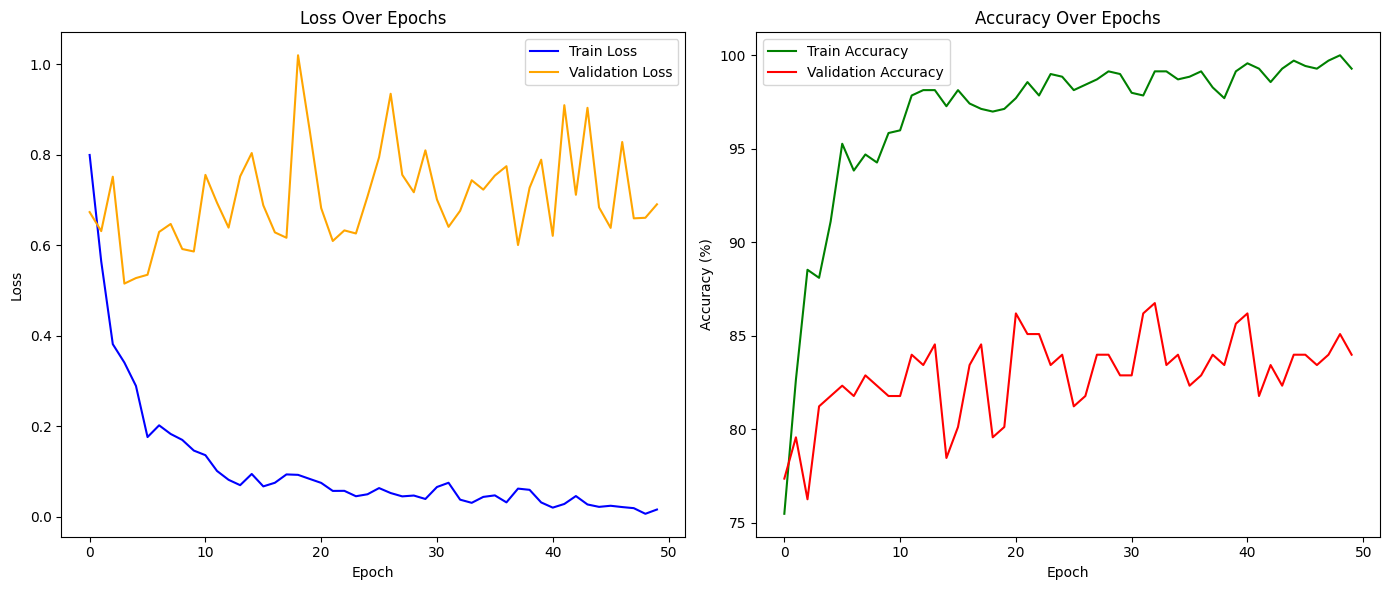

In [39]:
# Plot Metrics
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
# ✅ Evaluation on Test Dataset

# Switch to evaluation mode
inception_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Dataset"):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass without auxiliary outputs
        outputs = inception_model(images)
        if inception_model.aux_logits and isinstance(outputs, tuple):
            outputs = outputs[0]  # Primary output only
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



Evaluating on Test Dataset: 100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


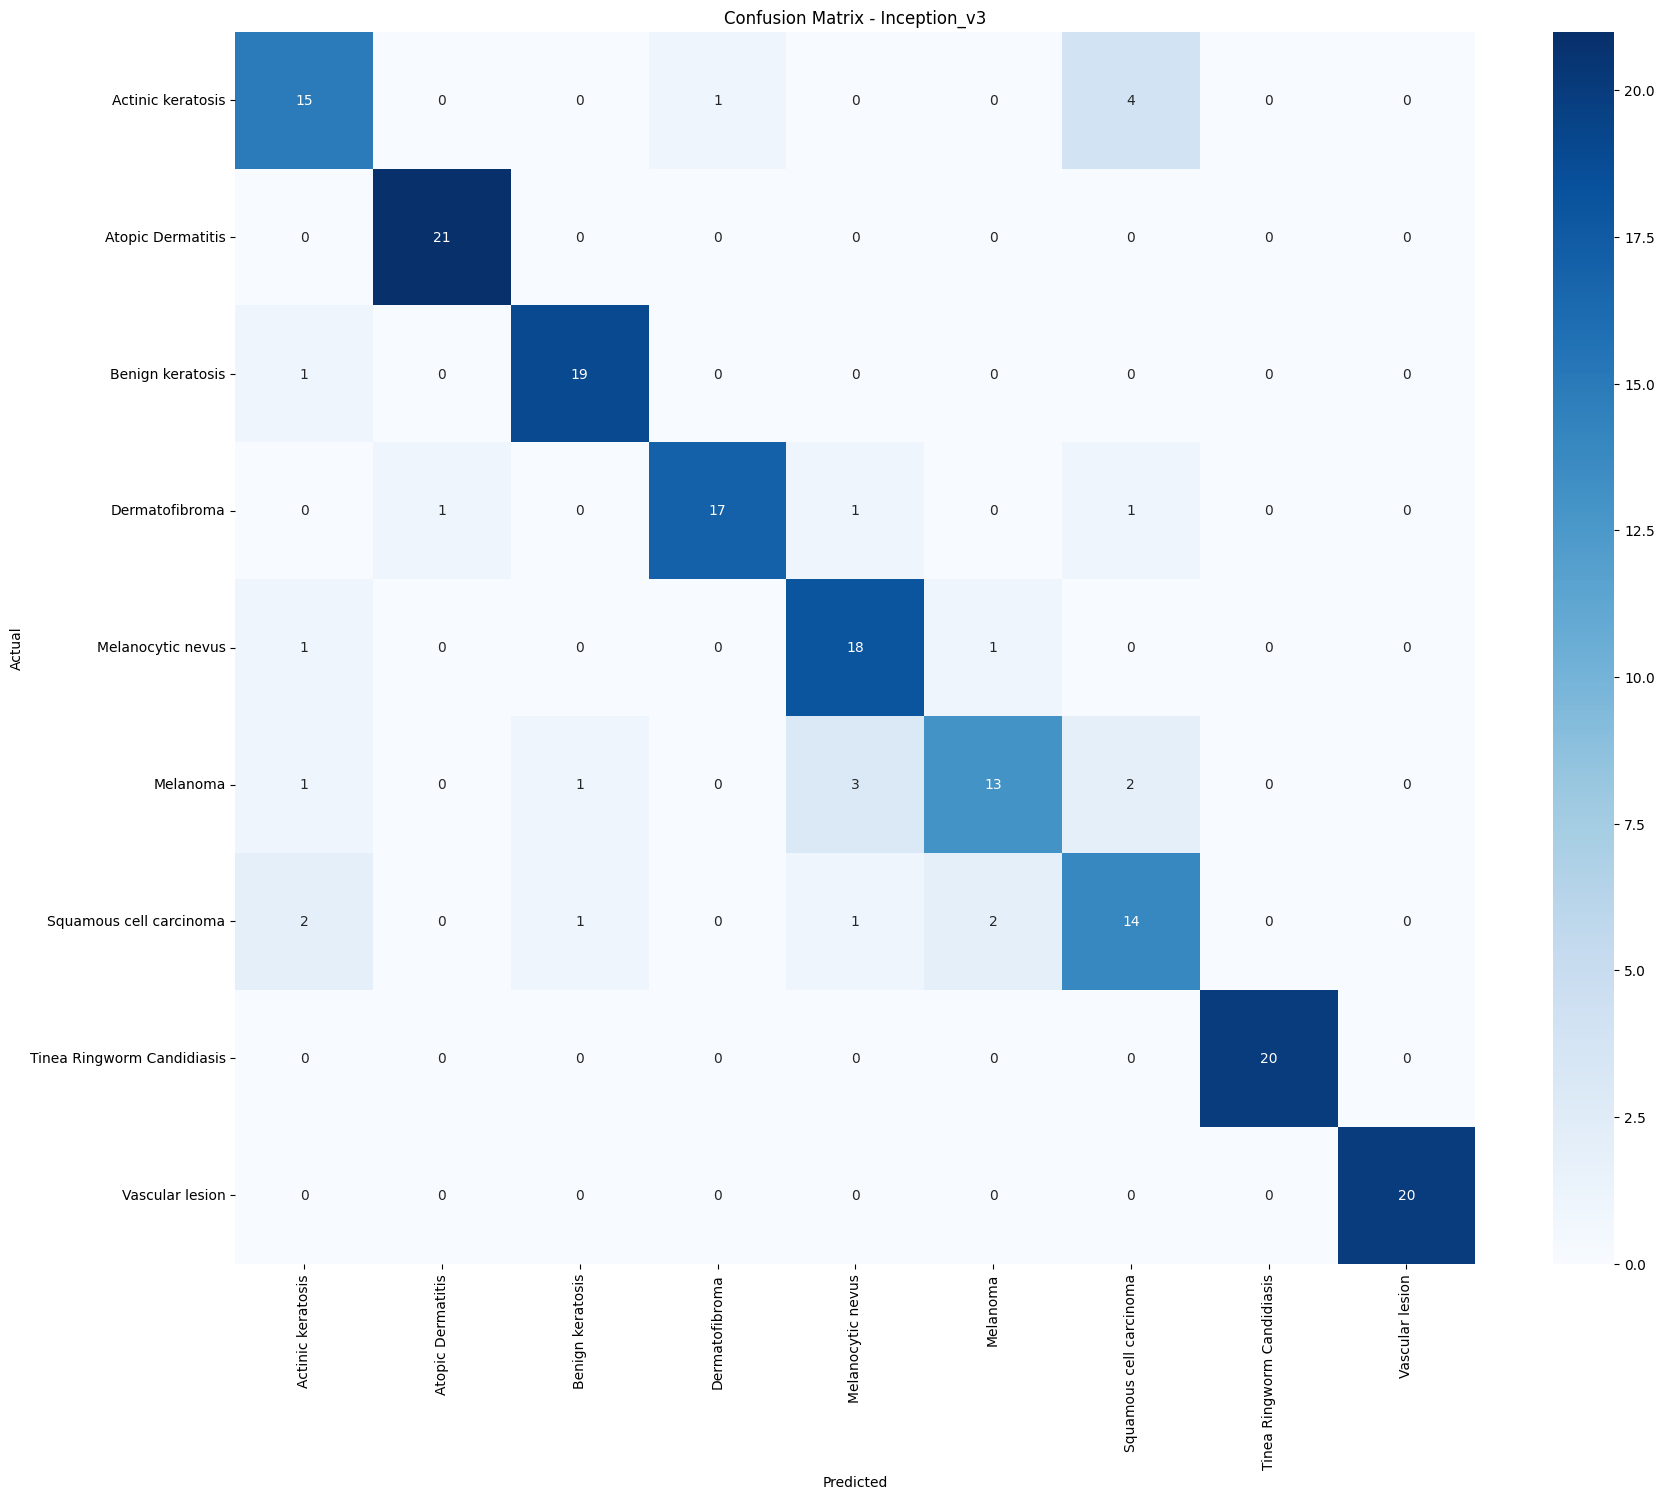

Classification Report:

                            precision    recall  f1-score   support

         Actinic keratosis       0.75      0.75      0.75        20
         Atopic Dermatitis       0.95      1.00      0.98        21
          Benign keratosis       0.90      0.95      0.93        20
            Dermatofibroma       0.94      0.85      0.89        20
         Melanocytic nevus       0.78      0.90      0.84        20
                  Melanoma       0.81      0.65      0.72        20
   Squamous cell carcinoma       0.67      0.70      0.68        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.87       181
                 macro avg       0.87      0.87      0.87       181
              weighted avg       0.87      0.87      0.87       181



In [42]:
# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Inception_v3')
plt.show()

# ✅ Classification Report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("Classification Report:\n")
print(report)


✅ Class Names Aligned Successfully: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


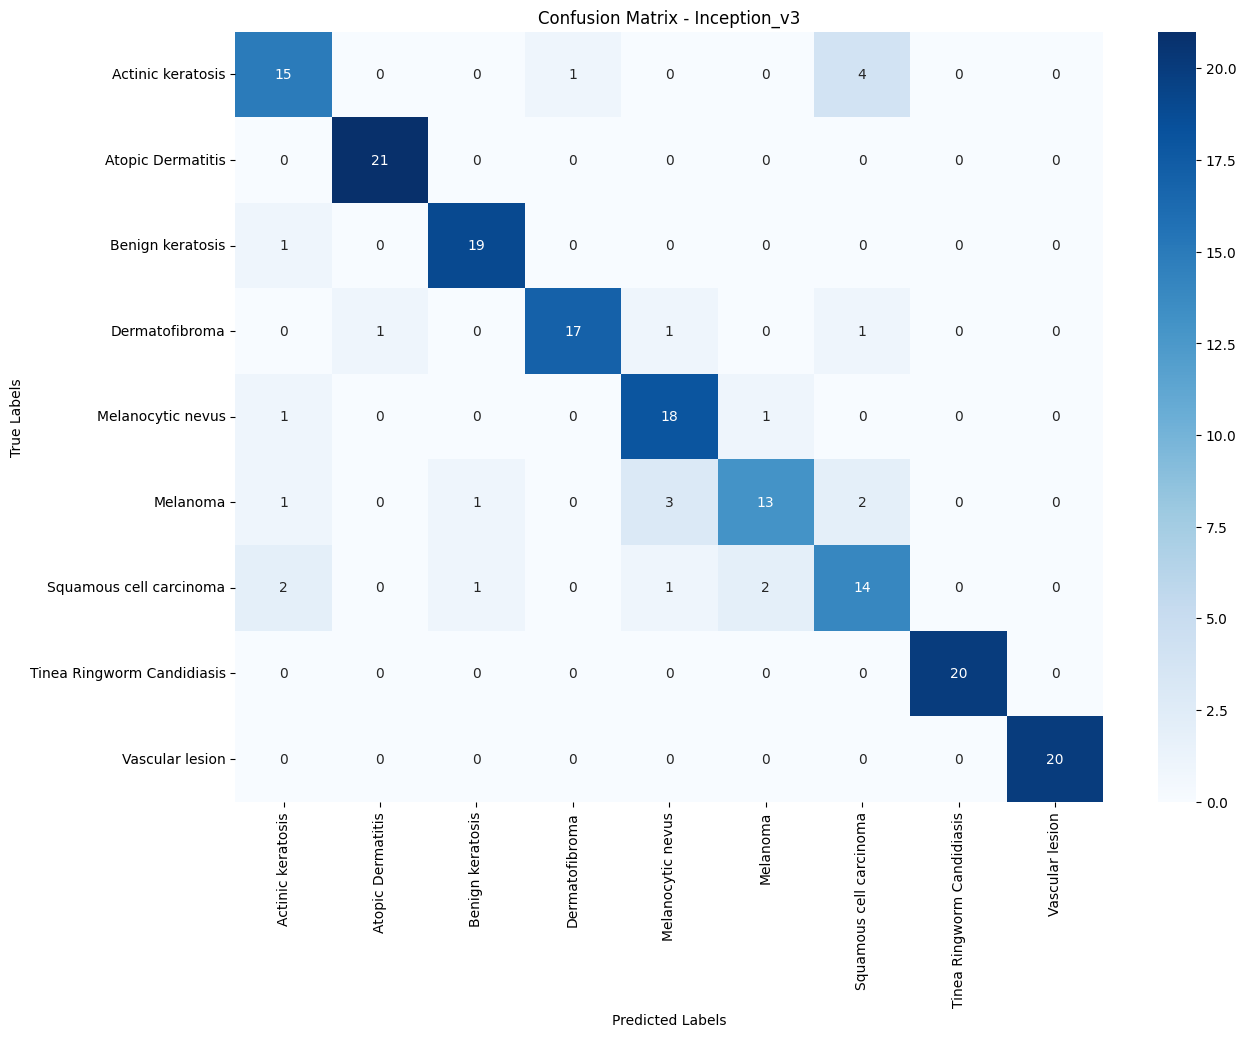

✅ Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.75      0.75      0.75        20
         Atopic Dermatitis       0.95      1.00      0.98        21
          Benign keratosis       0.90      0.95      0.93        20
            Dermatofibroma       0.94      0.85      0.89        20
         Melanocytic nevus       0.78      0.90      0.84        20
                  Melanoma       0.81      0.65      0.72        20
   Squamous cell carcinoma       0.67      0.70      0.68        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.87       181
                 macro avg       0.87      0.87      0.87       181
              weighted avg       0.87      0.87      0.87       181


✅ Overall Metrics:
🔹 Accuracy: 0.8674
🔹 Error Rate: 0.1326
🔹 Precision (Macro Avg): 0.8

In [43]:
# Additional Metrics Calculation

# Class Names
class_names = train_dataset.classes
print("✅ Class Names Aligned Successfully:", class_names)

# Confusion Matrix for Additional Metrics
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix - Inception_v3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Overall Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
error_rate = 1 - accuracy

# Specificity Calculation
def calculate_specificity_per_class(cm):
    specificity_per_class = []
    num_classes = cm.shape[0]
    
    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        specificity_per_class.append(specificity)
    
    specificity_avg = np.mean(specificity_per_class)
    return specificity_avg, specificity_per_class

specificity_avg, specificity_per_class = calculate_specificity_per_class(cm)

# Print Overall Metrics
print("\n✅ Overall Metrics:")
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Error Rate: {error_rate:.4f}")
print(f"🔹 Precision (Macro Avg): {precision:.4f}")
print(f"🔹 Recall (Macro Avg): {recall:.4f}")
print(f"🔹 F1-Score (Macro Avg): {f1:.4f}")
print(f"🔹 Specificity (Macro Avg): {specificity_avg:.4f}")

# Print Class-wise Specificity
print("\n✅ Specificity per Class:")
for i, spec in enumerate(specificity_per_class):
    print(f"🔹 {class_names[i]}: {spec:.4f}")


In [44]:
# Direct Evaluation after Loading
# If you need to load the model later, use the following code:

# Initialize the Inception_v3 model
# inception_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)

# Modify Fully Connected Layers
# num_classes = 9
# in_features_main = inception_model.fc.in_features
# inception_model.fc = nn.Linear(in_features_main, num_classes)

# if inception_model.aux_logits:
#     in_features_aux = inception_model.AuxLogits.fc.in_features
#     inception_model.AuxLogits.fc = nn.Linear(in_features_aux, num_classes)

# Move Model to Device
# inception_model = inception_model.to(device)

# Load the saved state dictionary
# model_save_path = '/kaggle/working/InceptionV3SkinClassifier_Best.pth'
# inception_model.load_state_dict(torch.load(model_save_path))
# inception_model.eval()
# print(f"✅ Loaded Model from {model_save_path}!")

# # Perform evaluation as done previously
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs, aux_outputs = inception_model(images)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Proceed with metrics calculation as in previous cells
